# Sample of VQ-VAE (only reconstruction)
### Dataset: 13515 images obtained by web scraping
### Feature map: Input (3x100x100) -> Encoded (64x25x25) -> Quantized (64x25x25) -> Decoded (3x100x100)
### Codebook size: 64x512

# Sample of VQ-VAE (only reconstruction)
### Dataset: 13515 images obtained by web scraping
### Feature map: Input (3x100x100) -> Encoded (64x25x25) -> Quantized (64x25x25) -> Decoded (3x100x100)
### Codebook size: 64x512

## Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import itertools
import os
import shutil
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

!nvidia-smi

cuda
Mon Aug 12 11:16:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   36C    P8              12W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

## Sample data

In [4]:
%%time
# Copy image file from my google drive to colab current directory
_ = shutil.copy("/content/drive/MyDrive/work/Sample/data/genshin/editted100x100.zip", "/content")

# Unzip
!unzip -qq "/content/editted100x100.zip"

CPU times: user 27.7 ms, sys: 123 ms, total: 150 ms
Wall time: 5.24 s


## Data infomation

In [5]:
# --------------------------------------------------
# Imfomation
# --------------------------------------------------
image_path = "/content/editted"
class_dirs = os.listdir(image_path)
image_files = [os.listdir(os.path.join(image_path, i)) for i in class_dirs]
sample_image = Image.open(os.path.join(image_path, class_dirs[0], image_files[0][0]))

print(f"No. of classes: {len(class_dirs)}")
print(f"Total no. of images: {np.sum([len(i) for i in image_files])}")
print(f"Image size: {sample_image.size}")
print(f"Minimum no. of images per class: {min([len(i) for i in image_files])}")
print(f"Maximum no. of images per class: {max([len(i) for i in image_files])}")

No. of classes: 82
Total no. of images: 13515
Image size: (100, 100)
Minimum no. of images per class: 20
Maximum no. of images per class: 282


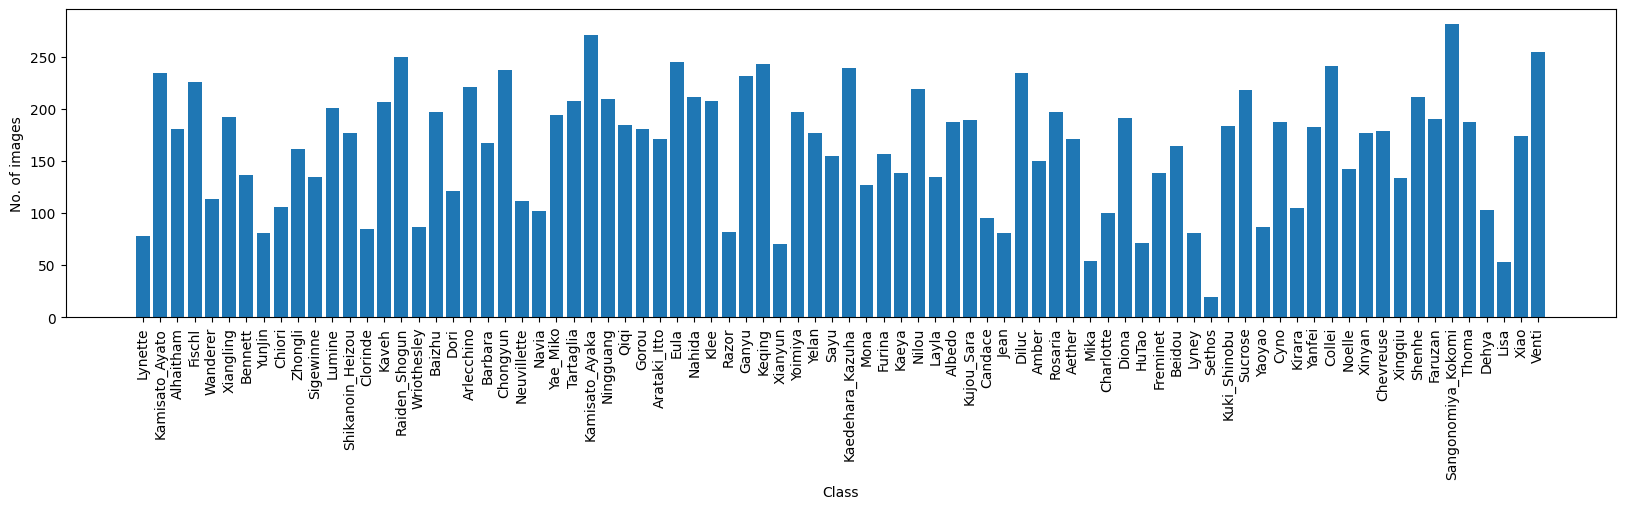

In [6]:
# --------------------------------------------------
# No. of images per classes
# --------------------------------------------------
plt.figure(figsize = (20, 4))
plt.bar(class_dirs, [len(i) for i in image_files])
plt.xticks(rotation = 90)
plt.xlabel("Class")
plt.ylabel("No. of images")
plt.show()

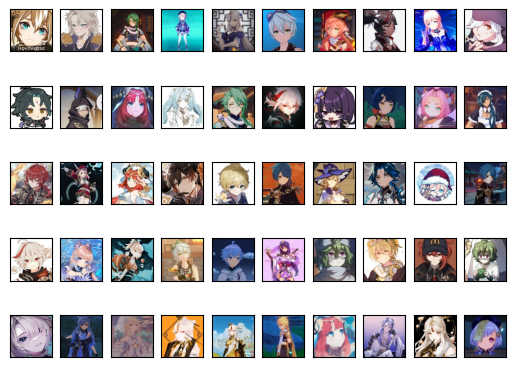

In [7]:
# --------------------------------------------------
# Show sample images
# --------------------------------------------------
def show_random_image(image_list: list):
    plot_image = np.random.choice(image_list, size = 50, replace = False)
    fig, ax = plt.subplots(5, 10)
    ax = ax.ravel()
    for i, image_path in enumerate(plot_image):
        image = Image.open(image_path)
        ax[i].imshow(image)
        ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)

image_list = list(itertools.chain.from_iterable([[os.path.join(image_path, d, f) for f in fs] for d, fs in zip(class_dirs, image_files)]))
show_random_image(image_list)

## Train-test split

In [8]:
# --------------------------------------------------
# Train-test split
# --------------------------------------------------

# Create directory
if os.path.isdir("train"):
    pass
else:
    os.mkdir("train")
    os.mkdir("test")

# Train-test split
test_image_num_per_class = 10
for class_name in class_dirs:

    # Reset & Create directory
    train_path = os.path.join("train", class_name)
    test_path = os.path.join("test", class_name)

    if os.path.isdir(train_path):
        shutil.rmtree(train_path)
        os.mkdir(train_path)
    else:
        os.mkdir(train_path)

    if os.path.isdir(test_path):
        shutil.rmtree(test_path)
        os.mkdir(test_path)
    else:
        os.mkdir(test_path)

    # Random split
    image_list = os.listdir(os.path.join(image_path, class_name))
    test_image_list = np.random.choice(image_list, size = test_image_num_per_class, replace = False)
    train_image_list = [i for i in image_list if i not in test_image_list]

    # Move image to train and test folder
    for image_file_name in test_image_list:
        _ = shutil.move(os.path.join(image_path, class_name, image_file_name), test_path)

    for image_file_name in train_image_list:
        _ = shutil.move(os.path.join(image_path, class_name, image_file_name), train_path)

# Splitted data information
print(f"No. of train images: {np.sum([len(os.listdir(os.path.join('train', i))) for i in os.listdir('train')])}")
print(f"No. of test images: {np.sum([len(os.listdir(os.path.join('test', i))) for i in os.listdir('test')])}")

No. of train images: 12695
No. of test images: 820


## Modeling

In [9]:
# --------------------------------------------------
# Data loader
# --------------------------------------------------

# Batch size
batch_size = 256

# Transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
])

# Dataset
train_dataset = torchvision.datasets.ImageFolder(root = "train", transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = "test", transform = test_transform)

# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [10]:
# --------------------------------------------------
# VQ-VAE Model
# --------------------------------------------------

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_residual_hiddens):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = num_residual_hiddens, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = num_residual_hiddens, out_channels = in_channels, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        h = torch.relu(x)
        h = self.conv1(h)
        h = torch.relu(h)
        h = self.conv2(h)
        return x + h

class StackedResidualBlock(nn.Module):
    def __init__(self, in_channels, num_residual_layers, num_residual_hiddens):
        super().__init__()
        self.num_residual_layers = num_residual_layers
        self.residual_blocks = nn.ModuleList([ResidualBlock(in_channels, num_residual_hiddens) for _ in range(self.num_residual_layers)])

    def forward(self, x):
        for i in range(self.num_residual_layers):
            x = self.residual_blocks[i](x)
        return torch.relu(x)

class PointwiseConv(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        return self.conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_residual_layers, residual_hidden_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim//2, kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size = 3, stride = 2, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(hidden_dim, num_residual_layers, residual_hidden_dim)

    def forward(self, x):
        out = self.conv1(x)
        out = torch.relu(out)
        out = self.conv2(out)
        out = torch.relu(out)
        out = self.stacked_residula_block(out)
        return out

class Decoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_residual_layers, residual_hidden_dim, out_dim, crop_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size = 3, stride = 1, padding = 1)
        self.stacked_residula_block = StackedResidualBlock(hidden_dim, num_residual_layers, residual_hidden_dim)
        self.t_conv1 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size = 4, stride = 2, padding = 0)
        self.t_conv2 = nn.ConvTranspose2d(hidden_dim//2, out_dim, kernel_size = 3, stride = 2, padding = 0)
        self.cener_crop = transforms.CenterCrop(crop_size)

    def forward(self, x):
        out = self.conv1(x)
        out = self.stacked_residula_block(out)
        out = self.t_conv1(out)
        out = torch.relu(out)
        out = self.t_conv2(out)
        out = self.cener_crop(out)
        #out = torch.sigmoid(out)
        return out

class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, beta):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta
        self.W = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.W.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, x):
        # N*C*H*W input convert to N*H*W*C shape
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.size()
        # Rshape
        input_flattened = x.view(-1, self.embedding_dim)
        # Distance
        distances = torch.sum(input_flattened**2, dim = 1, keepdim = True) -2*torch.matmul(input_flattened, self.W.weight.t()) + torch.sum(self.W.weight**2, dim = 1)
        encoding_indices = torch.argmin(distances, 1).unsqueeze(1)
        # To onhot vector
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device = x.device)
        encodings.scatter_(1, encoding_indices, 1)
        # Quantize
        quantized = torch.matmul(encodings, self.W.weight)
        quantized = quantized.view(input_shape)
        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized.detach(), x)
        embedding_loss = F.mse_loss(quantized, x.detach())
        vq_loss = commitment_loss*self.beta + embedding_loss
        # Strait-thorogh estimator
        quantized = x + (quantized - x).detach()
        return quantized.permute(0, 3, 1, 2).contiguous(), vq_loss

class VQVAE(nn.Module):
    def __init__(self, encoder, decoder, pointwise_conv, vector_quantizer, train_data_variance):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pointwise_conv = pointwise_conv
        self.vector_quantizer = vector_quantizer
        self.train_data_variance = train_data_variance

    def forward(self, x):
        # forward
        encoder_output = self.pointwise_conv(self.encoder(x))
        quantized_output, vq_loss = self.vector_quantizer(encoder_output)
        decoder_output = self.decoder(quantized_output)
        # Compute losses
        reconstruction_loss = F.mse_loss(decoder_output, x)/self.train_data_variance
        #reconstruction_loss = F.binary_cross_entropy(decoder_output, x, reduction = 'sum')
        loss = reconstruction_loss + vq_loss
        return decoder_output, encoder_output, quantized_output, loss

In [11]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
IMAGE_CHANNEL = 3
ENCODER_OUTPUT_CHANNEL = 128
NUM_RESIDUAL_LAYERS = 4
RESIDUAL_HIDDEN_DIM = 32
EMBEDDING_CHANNEL = 64
NUM_EMBEDDINGS = 512
BETA = 0.20
IMAGE_CROP_SIZE = 100
TRAIN_DATA_VARIANCE = 1.0

encoder = Encoder(IMAGE_CHANNEL, ENCODER_OUTPUT_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_DIM)
pointwise_conv = PointwiseConv(ENCODER_OUTPUT_CHANNEL, EMBEDDING_CHANNEL)
vector_quantizer = VectorQuantizer(EMBEDDING_CHANNEL, NUM_EMBEDDINGS, BETA)
decoder = Decoder(EMBEDDING_CHANNEL, ENCODER_OUTPUT_CHANNEL, NUM_RESIDUAL_LAYERS, RESIDUAL_HIDDEN_DIM, IMAGE_CHANNEL, IMAGE_CROP_SIZE)
model = VQVAE(encoder, decoder, pointwise_conv, vector_quantizer, TRAIN_DATA_VARIANCE)
model = model.to(device)

# Optimizer
lr = 3e-4
weight_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

[Epoch 100/100]: 100%|██████████| 49/49 [00:17<00:00,  2.81it/s]


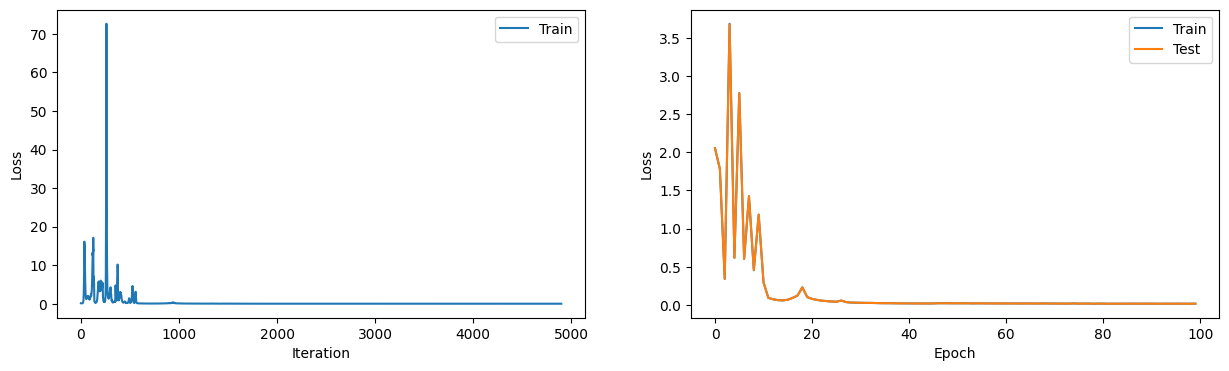

In [12]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Settings
epochs = 100
train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []

# Training
for epoch in range(epochs):

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch {epoch+1}/{epochs}]')

        # Traininig step
        model.train()
        for x, _ in pbar:
            x = x.to(device)
            decoder_output, encoder_output, quantized_output, loss = model(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_minibatch.append(loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            # Train loss
            losses = []
            for x, _ in train_loader:
                x = x.to(device)
                _, _, _, loss = model(x)
                losses.append(loss.item())
            train_loss_epoch.append(np.mean(losses))

            # Test loss
            for x, _ in test_loader:
                x = x.to(device)
                _, _, _, loss = model(x)
                losses.append(loss.item())
            test_loss_epoch.append(np.mean(losses))

# Loss plot
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(train_loss_epoch, label = "Train")
ax[1].plot(test_loss_epoch, label = "Test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.show()

In [13]:
# --------------------------------------------------
# Show reconstructed image (train)
# --------------------------------------------------

class InverseNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, input):
        for t, m, s in zip(input, self.mean, self.std):
            t.mul_(s).add_(m)
        return input

def compare_reconstruction_image(model, dataset, InverseNormalize):
    inverse_normalize = InverseNormalize(mean = [0.5, 0.5, 0.5], std = [1.0, 1.0, 1.0])
    image_num = len(dataset)
    plot_image_index = np.random.choice([i for i in range(image_num)], size = 25, replace = False)
    fig, ax = plt.subplots(5, 10, figsize = (20, 10))
    ax = ax.ravel()
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(plot_image_index):
            input = train_dataset[idx][0].to(device)
            input_size = input.size()
            reconstrunted_input, _, _, _ = model(input.view(1, input_size[0], input_size[1], input_size[2]))

            ax[i*2].imshow(inverse_normalize(input).permute(1, 2, 0).cpu())
            ax[i*2+1].imshow(np.clip(inverse_normalize(reconstrunted_input[0]).permute(1, 2, 0).cpu(), 0, 1))
            ax[i*2].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
            ax[i*2+1].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
            ax[i*2].set_title("Input")
            ax[i*2+1].set_title("Reconstruction")

# Show image
compare_reconstruction_image(model, train_dataset, InverseNormalize)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# --------------------------------------------------
# Show reconstructed image (test)
# --------------------------------------------------

# Show image
compare_reconstruction_image(model, test_dataset, InverseNormalize)

Output hidden; open in https://colab.research.google.com to view.